# Maps of italian regions

This notebook creates a simple lightweights map of any Italian region
currently set to 6 = FVG

1. create a json file of a single region from the complete geo-json source (italia_geo.json), which contains polygons and attributes (names and codes of regions, provinces, municipaities)
2. create a csv file with the coordinates of each municipality (center of corresponding polygon)
3. create grid file nxn that covers the whole region and saves to .csv

includes simple functions to load and plot map, points and grid
 



In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Create FVG_mappa.json base map from JSON

In [19]:
file=r"./maps/COMUNI/Italia_geo.json"

from pandas_geojson import read_geojson, filter_geojson
geo_json = read_geojson(file)
geo_json['type']


'FeatureCollection'

In [26]:
import pandas as pd
nn = len(geo_json['features'])
cols = [  'istat_r', 'istat_p','istat_c','nome', 'poly']
df = pd.DataFrame(columns=cols)
for i in range(nn):
    new_row = {'istat_r' : geo_json['features'][i]['properties']['reg_istat_code'], 
                'istat_p': geo_json['features'][i]['properties']['prov_istat_code'],
                'istat_c': geo_json['features'][i]['properties']['com_istat_code'],
                'nome'   : geo_json['features'][i]['properties']['name'],
                'poly'   : geo_json['features'][i]['geometry']['coordinates'][0][0]}
                   # consider only first polygon  
         
    df = df.append(new_row, ignore_index = True)
    
# save to a json file - not a standard format!    
df.to_json(r'./maps/FVG/FVG_mappa.json', orient='records')

In [29]:
df.to_json(r'./maps/FVG/FVG_mappa.json', orient='records')

In [27]:
df

,istat_r,istat_p,istat_c,nome,poly
0,01,001,001001,Agliè,"[[7.782661515272468, 45.38717349522259], [7.79..."
1,01,001,001002,Airasca,"[[7.48794558526873, 44.93917423980505], [7.493..."
2,01,001,001003,Ala di Stura,"[[7.273242283200158, 45.33927257986762], [7.27..."
3,01,001,001004,Albiano d'Ivrea,"[[7.925073017943036, 45.44820877844027], [7.92..."
4,01,001,001006,Almese,"[[7.434899721146957, 45.13441511853141], [7.43..."
...,...,...,...,...,...
7898,11,041,041071,Sassocorvaro Auditore,"[[12.592692313257219, 43.83641071071858], [12...."
7899,16,075,075098,Presicce-Acquarica,"[[18.2681658829262, 39.931480587100815], [18.2..."
7900,04,022,022252,Borgo d'Anaunia,"[[11.086483643056168, 46.520952153502485], [11..."
7901,04,022,022253,Novella,"[[11.06229832831365, 46.499188004074284], [11...."


In [111]:
def plot_map(df, color_fill = "green", alpha = .2, color_border= "gray" , linewidth = .8):
    for _, row in df.iterrows():
        x, y = list(zip(*row.poly)) 
        plt.fill(x,y, color = color_fill, alpha = alpha)
        plt.plot(x,y, color = color_border, linewidth=linewidth)
        
    


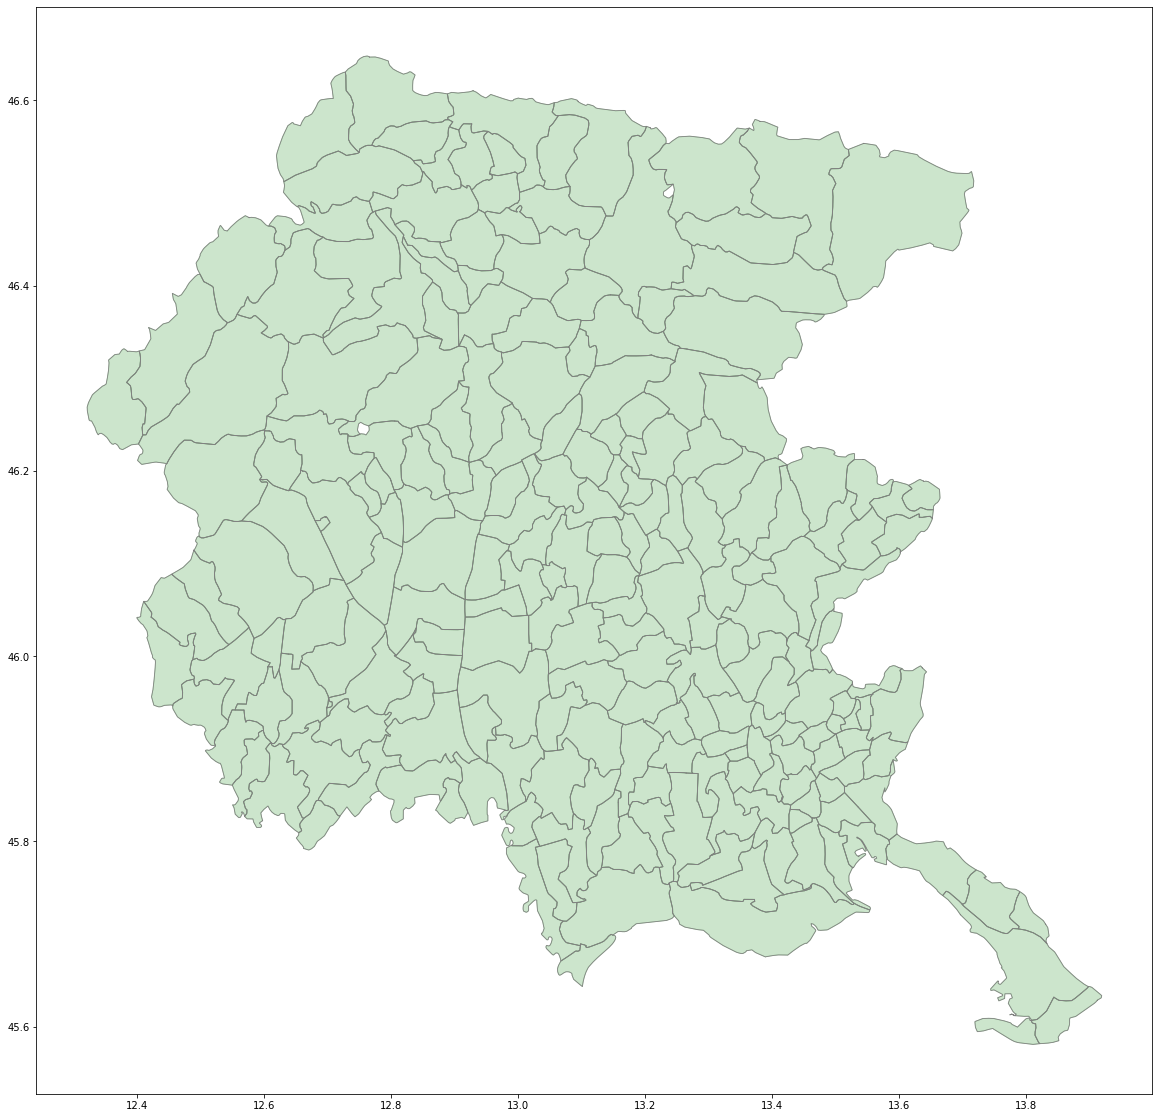

In [112]:
#load data from file
df = pd.read_json(r'./maps/FVG/FVG_mappa.json', orient='records')
# filter a single region
df=df[ df.istat_r==6]
# plot the map
fig, ax = plt.subplots(figsize=(20,20))
plot_map(df)
plt.show()

# Create a grid n x n 

In [79]:
# find min and max coordinates
x_min = df.iloc[0].poly[0][0]
x_max = x_min
y_min = df.iloc[0].poly[0][1]
y_max = y_min
for _, row in df.iterrows():
    x, y = list(zip(*row.poly)) 
    x_min = np.min(np.append(x,x_min))
    x_max = np.max(np.append(x,x_max))
    y_min = np.min(np.append(y,y_min))
    y_max = np.max(np.append(y,y_max))

x_min, x_max, y_min, y_max

(12.3209357495, 13.9188530967, 45.5809267176, 46.6478098111)

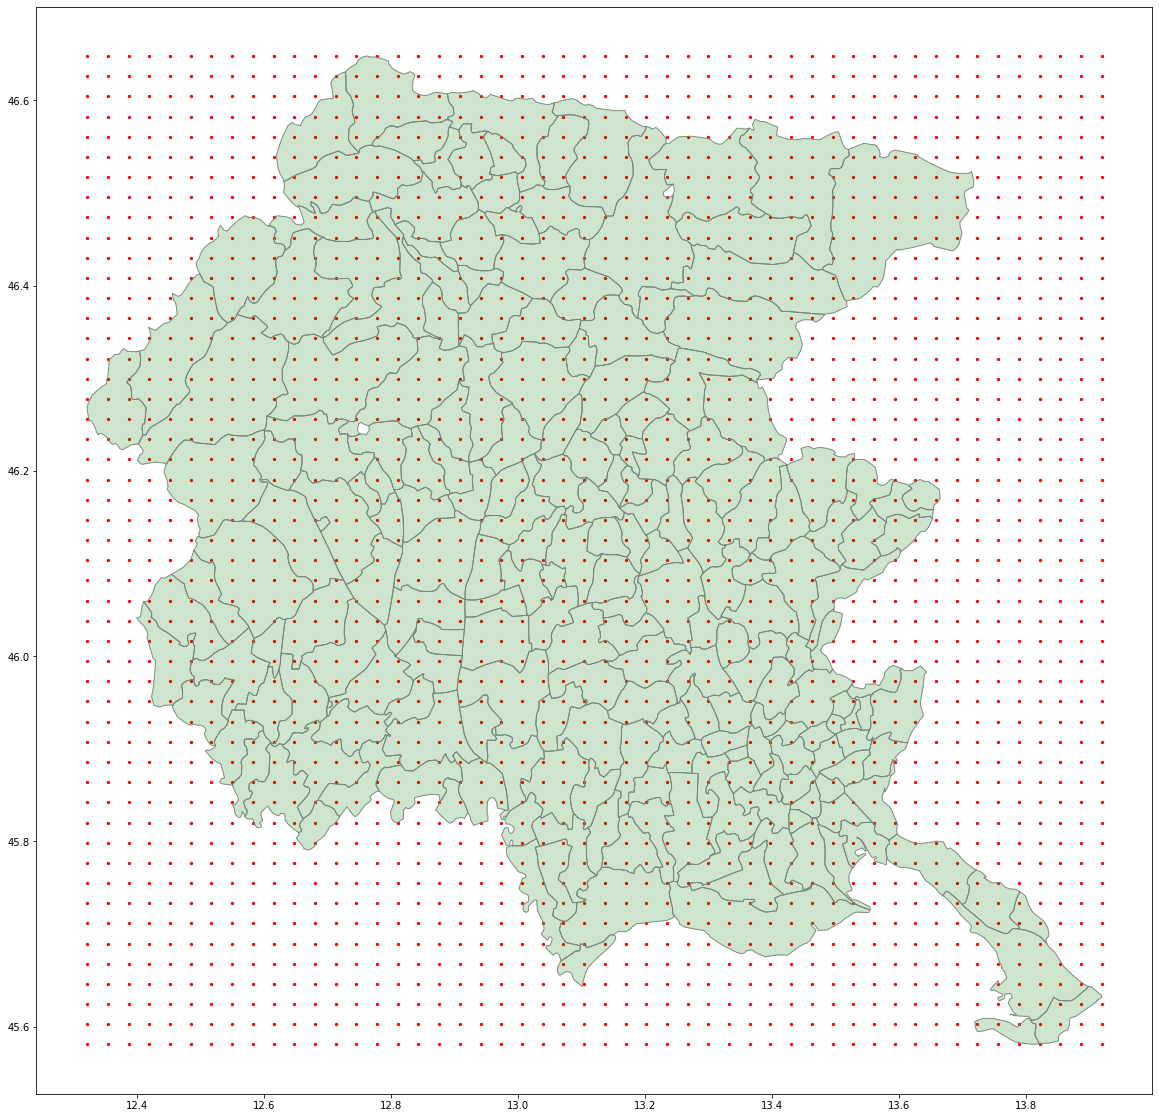

In [124]:
nn = 50
xx = np.linspace(x_min, x_max,nn)
yy = np.linspace(y_min, y_max,nn)
x_grid, y_grid = np.meshgrid(xx, yy, indexing='ij')

grid = pd.DataFrame(columns = ['x','y'])
grid['x']=np.reshape(x_grid,-1)
grid['y']=np.reshape(y_grid,-1)
grid.to_csv(r'./maps/FVG/FVG_grid.csv', index=False)


fig, ax = plt.subplots(figsize=(20,20))
plot_map(df)
plt.scatter(x_grid, y_grid, s=20, marker = '.', color = 'red')
plt.show()


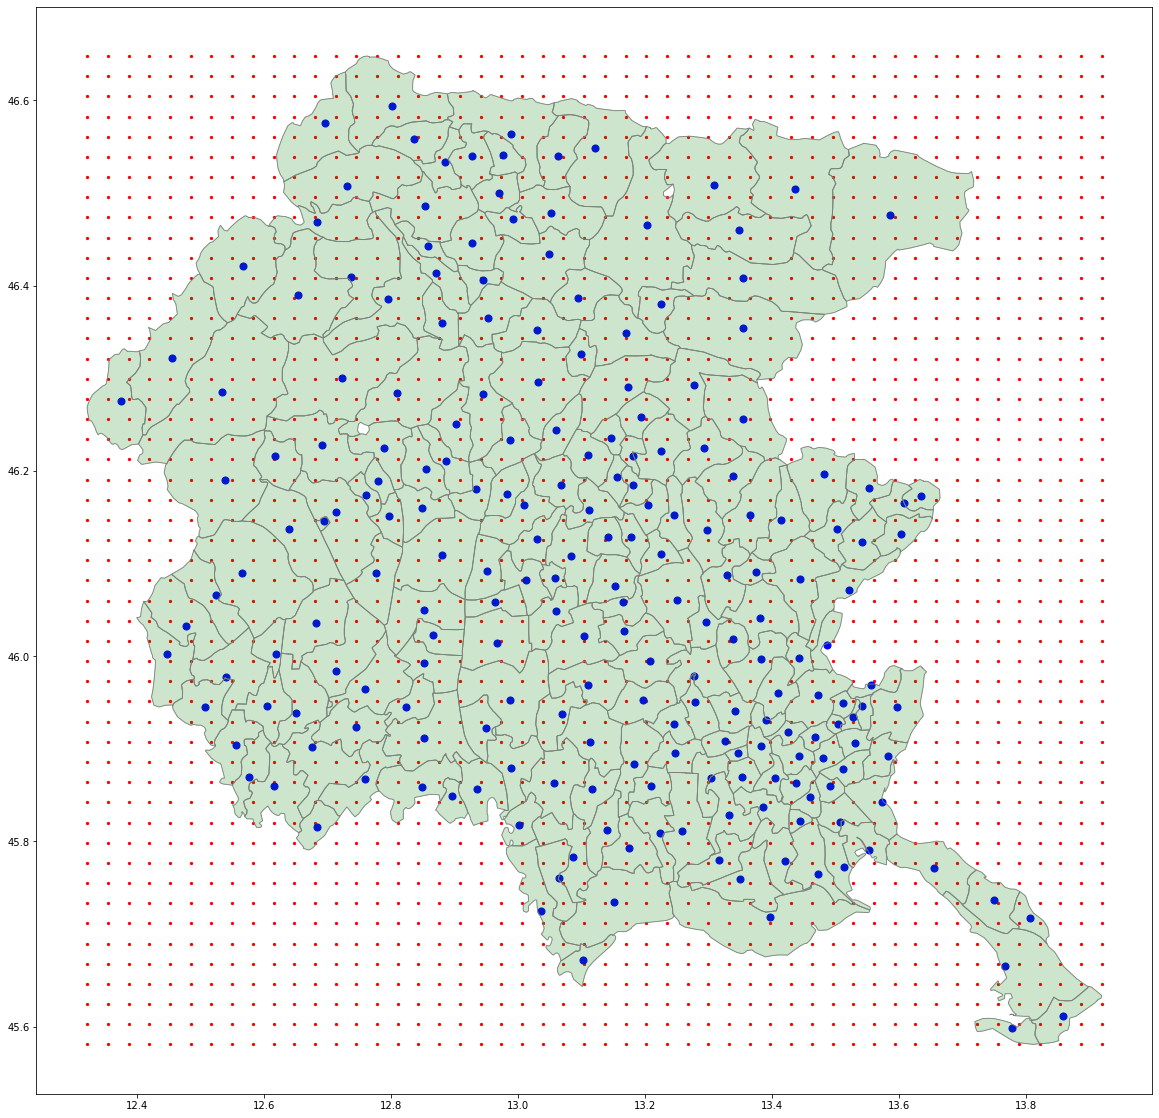

In [142]:
# find centroids
centroids = df#[  'istat_r', 'istat_p','istat_c','nome', 'poly']
xc = []
yc = []
for _, row in centroids.iterrows():
    x, y = list(zip(*row.poly)) 
    xc.append(np.mean(x))
    yc.append(np.mean(y))

centroids['xc']=xc
centroids['yc']=yc
cols_to_use = ['istat_r','istat_p','istat_c','nome','xc','yc']
centroids = centroids [cols_to_use]
centroids.to_csv(r'./maps/FVG/FVG_centroids.csv', index=False)

fig, ax = plt.subplots(figsize=(20,20))
plot_map(df)
plt.scatter(x_grid, y_grid, s=20, marker = '.', color = 'red')
plt.scatter(xc, yc,         s=50, marker = 'o', color = 'blue')
plt.show()

# companies

In [178]:
comp = pd.read_csv(r'./maps/FVG/FVG_companies.csv', dtype='str')
comp.columns = ['ind', 'cf', 'company','unit', 'lat', 'lon']
comp['lat'] = comp['lat'].astype(float)
comp['lon'] = comp['lon'].astype(float)
 

,ind,cf,company,unit,lat,lon
0,NaN,00079760328,ADRIA DIESEL S.R.L.,UL-1,45.954335,13.310425
1,". AUTOPORTO DOGANALE S.LEOPOLDO 4, 33016, PONT...",00521770321,FRANCESCO PARISI CASA DI SPEDIZIONI S.P.A.,UL-1,46.506568,13.305583
2,". MARINA DI AURISINA 153/L, 34011, DUINO AURIS...",00968120329,MOTOMARINE - SOCIETA A RESPONSABILITA LIMITATA,UL-12,45.750680,13.669504
3,". SAN ELISEO 21/C, 33030, MAJANO, UD",00325520302,COKE STRADE S.R.L.,UL-1,46.168203,13.091555
4,". TANGENZIALE OVEST VIA VENEZIA 1, 33010, TAVA...",00991520305,SOM S.P.A.,UL-1,46.116984,13.219870
...,...,...,...,...,...,...
7950,"ZONA INDUSTRIALE UDINESE, 33050, PAVIA DI UDIN...",00992960302,FACS FUCINE S.R.L.,UL-3,45.996285,13.302528
7951,"ZONA INDUSTRIALE VIA REMIS 17, 33050, SAN VITO...",02069870307,SEDIL CURVI S.R.L.,UL-3,45.895321,13.371934
7952,"ZONA INDUSTRIALE VIA S. MARCO 17, 33099, VIVAR...",00412260937,CENTRO SERVIZI DOGANALI - S.P.A.,UL-8,46.078226,12.776906
7953,"ZONA INDUSTRIALE, 33085, MANIAGO, PN",01041280932,VECAR S.R.L.,UL-3,46.165086,12.706567


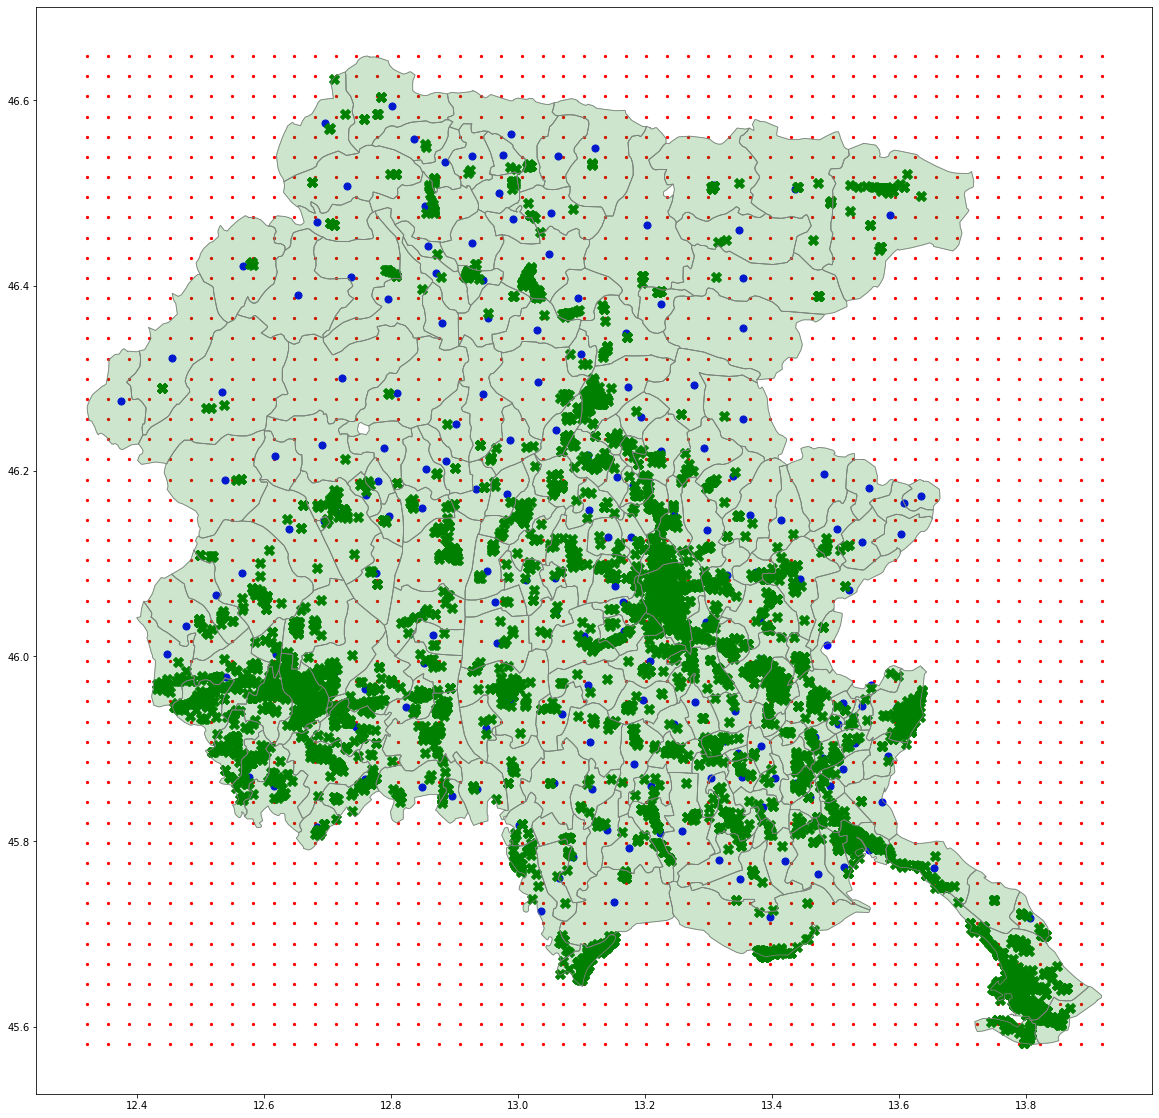

In [185]:
fig, ax = plt.subplots(figsize=(20,20))
plot_map(df)
plt.scatter(x_grid, y_grid, s=20, marker = '.', color = 'red')
plt.scatter(xc, yc,         s=50, marker = 'o', color = 'blue')

x = comp['lon']
y = comp['lat']
plt.scatter(x,y, color = "green", marker = "X", s=100)
plt.show()
